In [1]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from bert import tokenization
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input, Dropout, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
from tensorflow.keras import initializers
import tensorflow_hub as hub




import warnings
warnings.filterwarnings("ignore")

### Loading Clean Data 

In [15]:
train = pd.read_csv('clean_train.csv')
test = pd.read_csv('clean_test.csv')

target = pd.read_csv('target.csv')

In [18]:
train['text']

0       Our Deeds Reason earthquake May ALLAH Forgive us 
1                   Forest fire near La Ronge Sask Canada
2       All residents asked shelter place notified off...
3       13000 people receive wildfires evacuation orde...
4       Just got sent photo Ruby Alaska smoke wildfire...
                              ...                        
7608    Two giant cranes holding bridge collapse nearb...
7609    ariaahrary TheTawniest The control wild fires ...
7610                  M194 0104 UTC5km S Volcano Hawaii  
7611    Police investigating ebike collided car Little...
7612    The Latest More Homes Razed Northern Californi...
Name: text, Length: 7613, dtype: object

### Data Splitting 

In [3]:
train, cv, y_train, y_cv = train_test_split(train['text'], target, test_size = 0.2, random_state = 42)

### Vectorization 

### GloVe 

In [4]:
embeddings_dict = dict()

f = open('glove.6B.100d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_dict[word] = coefs
f.close()

In [5]:
max_words = 100000
max_sequence_length = 50
embedding_dim = 100

In [9]:
tf.keras.backend.clear_session()

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train)
train_padded = pad_sequences(train_sequences, padding = 'post', truncating = 'post', maxlen = max_sequence_length)

cv_sequences = tokenizer.texts_to_sequences(cv)
cv_padded = pad_sequences(cv_sequences, padding = 'post', truncating = 'post', maxlen = max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences, padding = 'post', truncating = 'post', maxlen = max_sequence_length)

In [10]:
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
joblib.dump(train_padded, 'train_padded.pkl')
joblib.dump(cv_padded, 'cv_padded.pkl')
joblib.dump(test_padded, 'test_padded.pkl')

['test_padded.pkl']

In [12]:
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

### BERT 

In [39]:
def bert_encode(texts, tokenizer, max_len = 512):
    
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [40]:
max_seq_length = 160

input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs = sequence_output[:, 0, :])

In [41]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [42]:
train_input = bert_encode(train, tokenizer, max_len = 160)
cv_input = bert_encode(cv, tokenizer, max_len = 160)
test_input = bert_encode(test, tokenizer, max_len = 160)

In [43]:
# train_bert = bert_model.predict([train_input])
# cv_bert = bert_model.predict([cv_input])
# test_bert = bert_model.predict([test_input])

In [55]:
train_bert = joblib.load('train_bert.pkl')
cv_bert = joblib.load('cv_bert.pkl')
test_bert = joblib.load('test_bert.pkl')

### Models 

### LSTM + GloVe 

In [56]:
input_layer = Input(shape = (50, ))
embedding = Embedding(input_dim = vocab_size, output_dim = embedding_dim, weights = [embedding_matrix], input_length = 50)(input_layer)
lstm = LSTM(32, return_sequences = True, recurrent_dropout = 0.5)(embedding)
flatten = Flatten()(lstm)
dense_1 = Dense(300, activation = "relu", kernel_initializer = "he_normal")(flatten)
dropout = Dropout(0.5)(dense_1)
dense_2 = Dense(200, activation="relu", kernel_initializer = "glorot_normal")(dropout)
normalization = BatchNormalization()(dense_2)
dropout_1 = Dropout(0.5)(normalization)
dense_3 = Dense(80, activation = "relu", kernel_initializer= "glorot_normal" )(dropout_1)
output = Dense(2, activation = 'softmax')(dense_3)

model = Model(inputs = input_layer, outputs = output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 100)           1567600   
                                                                 
 lstm_2 (LSTM)               (None, 50, 32)            17024     
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 300)               480300    
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               6020

In [57]:
checkpoint = ModelCheckpoint("lstm_model.h5", monitor="val_f1_score", mode="max", save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_f1_score', mode="max", min_delta = 0, patience = 1)

%load_ext tensorboard
!rm -rf ./logs/ 
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

callbacks = [checkpoint, earlystop, tensorboard]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [58]:
y_train_ = to_categorical(y_train)
y_cv_ = to_categorical(y_cv)

In [59]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = [tfa.metrics.F1Score(num_classes =  2, average = 'micro')])

history = model.fit(train_padded, y_train_, epochs=10, verbose=1,callbacks = callbacks, validation_data = (cv_padded, y_cv_))

Epoch 1/10
191/191 [==============================] - 33s 132ms/step - loss: 0.5495 - f1_score: 0.7476 - val_loss: 0.4674 - val_f1_score: 0.7978
Epoch 2/10
191/191 [==============================] - 21s 108ms/step - loss: 0.4274 - f1_score: 0.8205 - val_loss: 0.4273 - val_f1_score: 0.8181
Epoch 3/10
191/191 [==============================] - 20s 106ms/step - loss: 0.3508 - f1_score: 0.8544 - val_loss: 0.4778 - val_f1_score: 0.8083


In [62]:
y_train_pred = model.predict(train_padded)

191/191 [==============================] - 4s 17ms/step


In [106]:
y_cv_pred = model.predict(cv_padded)

48/48 [==============================] - 1s 21ms/step


In [81]:
y_train_pred_final = []
for ele in list(y_train_pred):
    if ele[0] > ele[1]:
        y_train_pred_final.append(0)
    else:
        y_train_pred_final.append(1)       

In [83]:
y_cv_pred_final = []
for ele in list(y_cv_pred):
    if ele[0] > ele[1]:
        y_cv_pred_final.append(0)
    else:
        y_cv_pred_final.append(1)       

In [96]:
train_cm = tf.math.confusion_matrix(y_train, y_train_pred_final)

In [97]:
validation_cm = tf.math.confusion_matrix(y_cv, y_cv_pred_final)

#### Train Confusion Matrix 

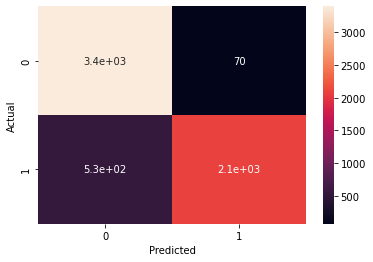

In [104]:
sn.heatmap(train_cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Validation Confusion Matrix 

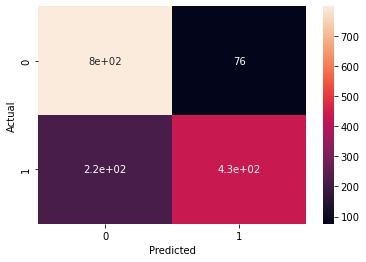

In [105]:
sn.heatmap(validation_cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Neural Network + BERT 

In [108]:
input_layer = Input(shape = (train_bert.shape[1], ))

layer1 = Dense(50, activation = 'relu', kernel_initializer = initializers.HeUniform(seed = 0))(input_layer)
layer2 = Dense(50, activation = 'relu', kernel_initializer = initializers.HeUniform(seed = 0))(layer1)
layer3 = Dense(50, activation = 'relu', kernel_initializer = initializers.HeUniform(seed = 0))(layer2)
layer4 = Dense(50, activation = 'relu', kernel_initializer = initializers.HeUniform(seed = 0))(layer3)

output = Dense(2, activation = 'softmax', kernel_initializer = initializers.RandomUniform(0, 1, seed = 0))(layer4)

model = Model(inputs = input_layer, outputs = output)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_12 (Dense)            (None, 50)                38450     
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 2)                 102       
                                                                 
Total params: 46,202
Trainable params: 46,202
Non-trainable

In [109]:
checkpoint = ModelCheckpoint("bert_model.h5", monitor="val_f1_score", mode="max", save_best_only = True)
callbacks = [checkpoint, earlystop, tensorboard]
optimizer = tf.keras.optimizers.Adam()

In [110]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = [tfa.metrics.F1Score(num_classes =  2, average = 'micro')])

history = model.fit(train_bert, y_train_, epochs = 10, validation_data = (cv_bert, y_cv_), callbacks = callbacks, verbose = 1)

Epoch 1/10
191/191 [==============================] - 18s 18ms/step - loss: 0.7277 - f1_score: 0.6841 - val_loss: 0.5624 - val_f1_score: 0.7682
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.5077 - f1_score: 0.7905 - val_loss: 0.4996 - val_f1_score: 0.7768
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4494 - f1_score: 0.8034 - val_loss: 0.4559 - val_f1_score: 0.7905
Epoch 4/10
191/191 [==============================] - 2s 8ms/step - loss: 0.4297 - f1_score: 0.8135 - val_loss: 0.4471 - val_f1_score: 0.7958
Epoch 5/10
191/191 [==============================] - 2s 8ms/step - loss: 0.4134 - f1_score: 0.8184 - val_loss: 0.4519 - val_f1_score: 0.7971
Epoch 6/10
191/191 [==============================] - 2s 8ms/step - loss: 0.4046 - f1_score: 0.8238 - val_loss: 0.4474 - val_f1_score: 0.7997
Epoch 7/10
191/191 [==============================] - 1s 8ms/step - loss: 0.3987 - f1_score: 0.8225 - val_loss: 0.4521 - val_f1_score: 0.7984


In [111]:
y_train_pred = model.predict(train_bert)
y_cv_pred = model.predict(cv_bert)

y_train_pred_final = []
for ele in list(y_train_pred):
    if ele[0] > ele[1]:
        y_train_pred_final.append(0)
    else:
        y_train_pred_final.append(1) 
        
y_cv_pred_final = []
for ele in list(y_cv_pred):
    if ele[0] > ele[1]:
        y_cv_pred_final.append(0)
    else:
        y_cv_pred_final.append(1)  
        
train_cm = tf.math.confusion_matrix(y_train, y_train_pred_final)
validation_cm = tf.math.confusion_matrix(y_cv, y_cv_pred_final)

48/48 [==============================] - 0s 4ms/step


#### Train Confusion Matrix 

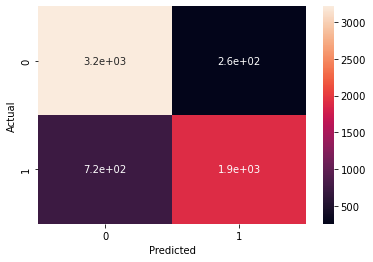

In [112]:
sn.heatmap(train_cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Validation Confusion Matrix 

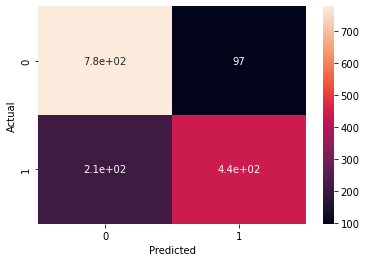

In [113]:
sn.heatmap(validation_cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### XGBoost + BERT

In [116]:
xgb = XGBClassifier(random_state = 42, n_jobs = -1) 

parameters = {'learning_rate':[0.001,0.01,0.05,0.1,1], 
              'n_estimators':[100,150,200,500], 
              'max_depth':[2,3,5,10], 
              'colsample_bytree':[0.1,0.5,0.7,1], 
              'subsample':[0.2,0.3,0.5,1], 
              'gamma':[1e-2,1e-3,0,0.1,0.01,0.5,1],             
              'reg_alpha':[1e-5,1e-3,1e-1,1,1e1]} 

reg = RandomizedSearchCV(xgb,parameters,cv=5, scoring='r2', return_train_score=True, n_jobs=-1, verbose=10) 
best_clf = reg.fit(train_bert, y_train)
best_param = best_clf.best_estimator_.get_params()
print(best_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[23:51:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.1, 'enable_categorical': False, 'gamma': 1, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': -1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0.001, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [131]:
xgb = XGBClassifier(learning_rate = 0.01, n_estimators = 150, max_depth = 10, colsample_bytree = 0.1, subsmaple = 0.3, gamma = 1, reg_alpha = 0.001)
xgb.fit(train_bert, y_train)



y_pred_train = xgb.predict(train_bert)
y_pred_cv = xgb.predict(cv_bert)

[00:04:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "subsmaple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:04:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [132]:
f1_score(y_train, y_pred_train)

0.971150097465887

In [133]:
f1_score(y_cv, y_pred_cv)

0.7312925170068026

##### LSTM + Glove is the Best model to classify 

In [1]:
import tensorflow_addons

In [2]:
s = 'how are you'

s = [s]

In [3]:
s

['how are you']

In [1]:
import joblib

train_padded = joblib.load('train_padded.pkl')
cv_padded = joblib.load('cv_padded.pkl')
test_padded = joblib.load('test_padded.pkl')

In [2]:
print(train_padded.shape)
print(cv_padded.shape)
print(test_padded.shape)

(6090, 50)
(1523, 50)
(3263, 50)
